In [ ]:
from __future__ import division, print_function, absolute_import
import torch
import torch.nn as nn
import torch.nn.functional as F

import csv
import sys
import datetime
import pywt
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import defaultdict, Counter
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization
from keras.layers.core import Dense, Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
import keras
from scipy.stats import itemfreq
import os
from keras import models
from keras import layers

from numpy import pi, linspace, inf, array
from scipy.interpolate import interp1d
from torch.utils.data import Dataset, DataLoader,TensorDataset


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [ ]:
torch.cuda.device_count()

1

In [ ]:


posttraimodel = pd.read_excel('/content/drive/My Drive/Files/TE/train-inverse-all-spectra.xlsx')

#test = pd.read_excel('/content/drive/My Drive/Files/TM/test-autoencoder-wpt1t2-500-700nm(eps-std)(non spectra).xlsx')
test = pd.read_excel('/content/drive/My Drive/Files/TE/test-inverse-all-spectra.xlsx')

print(posttraimodel.shape, test.shape)

forward_model = torch.load('/content/drive/My Drive/Files/TE/forward model/pt2gapt-spectra-reduced arch-all design-1.pt')


x_inverse = np.array(posttraimodel)[:,4:]

x_test = np.array(test)[:,4:]

y_inverse = np.array(posttraimodel)[:,:4]

y_test = np.array(test)[:,:4]
print(y_inverse.shape, x_inverse.shape)



(4050, 124) (450, 124)
(4050, 4) (4050, 120)


In [ ]:


#x_train_all, x_test, y_train_all, y_test = model_selection.train_test_split(x_inverse, y_inverse, test_size = 0.1)
x_train_inv, x_val_inv, y_train_inv, y_val_inv = model_selection.train_test_split(x_inverse, y_inverse, test_size = 0.1)
in_dim = x_train_inv.shape[1]
out_dim = y_train_inv.shape[1]

print(in_dim,",",out_dim)

X_train = torch.from_numpy(x_train_inv).float()
y_train = torch.squeeze(torch.from_numpy(y_train_inv).float())
X_val = torch.from_numpy(x_val_inv).float()
y_val = torch.squeeze(torch.from_numpy(y_val_inv).float())
X_test = torch.from_numpy(x_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test).float())
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

# Hyperparameters for our network
input_size = in_dim
# Hyperparameters for our network
hidden_sizes = [90,180,450, 600,750,500,300,120,60]#[90,180,450, 600,750,500,300,120,60]#[180,450, 600,250,150]#
output_size = out_dim
# Build a feed-forward network


model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.SiLU(),
                      nn.BatchNorm1d(hidden_sizes[0]),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.Tanh(),
                      nn.BatchNorm1d(hidden_sizes[1]),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.SiLU(),
                      nn.BatchNorm1d(hidden_sizes[2]),
                      nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                      nn.Tanh(),
                      nn.BatchNorm1d(hidden_sizes[3]),
                      nn.Linear(hidden_sizes[3], hidden_sizes[4]),
                      nn.SiLU(),
                      nn.BatchNorm1d(hidden_sizes[4]),
                      nn.Linear(hidden_sizes[4], hidden_sizes[5]),
                      nn.Tanh(),
                      nn.BatchNorm1d(hidden_sizes[5]),
                      nn.Linear(hidden_sizes[5], hidden_sizes[6]),
                      nn.SiLU(),
                      nn.BatchNorm1d(hidden_sizes[6]),
                      nn.Linear(hidden_sizes[6], hidden_sizes[7]),
                      nn.Tanh(),
                      nn.BatchNorm1d(hidden_sizes[7]),
                      nn.Linear(hidden_sizes[7], hidden_sizes[8]),
                      nn.SiLU(),
                      nn.BatchNorm1d(hidden_sizes[8]),
                      nn.Linear(hidden_sizes[8], output_size),
                      nn.Sigmoid())

print(model)

120 , 4
torch.Size([3645, 120]) torch.Size([3645, 4])
torch.Size([405, 120]) torch.Size([405, 4])
Sequential(
  (0): Linear(in_features=120, out_features=90, bias=True)
  (1): SiLU()
  (2): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=90, out_features=180, bias=True)
  (4): Tanh()
  (5): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=180, out_features=450, bias=True)
  (7): SiLU()
  (8): BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=450, out_features=600, bias=True)
  (10): Tanh()
  (11): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=600, out_features=750, bias=True)
  (13): SiLU()
  (14): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Linear(in_features=750, out_features=500, bias=True)
  (16): Tanh()
  

In [ ]:
model.to(device)

Sequential(
  (0): Linear(in_features=120, out_features=90, bias=True)
  (1): SiLU()
  (2): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=90, out_features=180, bias=True)
  (4): Tanh()
  (5): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=180, out_features=450, bias=True)
  (7): SiLU()
  (8): BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=450, out_features=600, bias=True)
  (10): Tanh()
  (11): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=600, out_features=750, bias=True)
  (13): SiLU()
  (14): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Linear(in_features=750, out_features=500, bias=True)
  (16): Tanh()
  (17): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (18): Lin

In [ ]:
total = pd.read_excel('/content/drive/My Drive/Files/TE/TE_500_700nm_all_design.xlsx')



total["gap"] = total["p"] - 2*total["w"]
total["t"] = total["t1"] + total["t2"]

min_real = min(total["Re(r)"])
max_real = max(total["Re(r)"])

min_img = min(total["Img(r)"])
max_img = max(total["Img(r)"])

min_abs = min(total["A"])
max_abs = max(total["A"])

min_t1 = min(total["t1"]) + 1j*(0)
max_t1 = max(total["t1"]) + 1j*(0)

min_t2 = min(total["t2"]) + 1j*(0)
max_t2 = max(total["t2"]) + 1j*(0)

min_t = min(total["t"]) + 1j*(0)
max_t = max(total["t"]) + 1j*(0)

max_w = max(total["w"]) + 1j*(0)
max_p = max(total["p"]) + 1j*(0)

min_w = min(total["w"]) + 1j*(0)
min_p = min(total["p"]) + 1j*(0)

max_gap = max(total["gap"]) + 1j*(0)
min_gap = min(total["gap"]) + 1j*(0)


ref = pd.read_excel('/content/drive/My Drive/Files/TE/TE wvl and eps-40.xlsx')
ref = np.array(ref)

max_eps_real = max(ref[:,1])
min_eps_real = min(ref[:,1])

max_eps_img = max(ref[:,2])
min_eps_img = min(ref[:,2])
wvl_unshuffled = np.array(pd.read_excel('/content/drive/My Drive/Files/TE/TE wvl and eps-40.xlsx'))



In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device), X_test.to(device), \
y_test.to(device)

output = model(X_train)
criterion = nn.L1Loss()#nn.MSELoss() #nn.BCELoss()
#optimizer = torch.optim.AdamW(model.parameters(),lr=0.009)#,weight_decay=  0.00001)#0.001
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0015)#,weight_decay=  0.00001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.9,patience=10,min_lr=1e-06, verbose=True)

In [ ]:
wvl_list = np.array(pd.read_excel('/content/drive/My Drive/Files/TE/TE wvl and eps-40.xlsx'))
wvl_list =  torch.from_numpy(wvl_list).float()

wvl_num = len(wvl_list)


def make_long_table(ytrue,ypred,X):#X=response, y = design

  design_temp_true = torch.repeat_interleave(ytrue, 40, dim=0)#
  design_temp_pred = torch.repeat_interleave(ypred,40, dim=0)#repeat the entire block


  wvl_temp = torch.t(torch.tile(wvl_list[:,0],(1,len(ytrue))))
  # print("each wavelength",wvl_temp)
  eps_real_temp = torch.t(torch.tile(wvl_list[:,1],(1,len(ytrue))))#not standardised
  eps_imag_temp = torch.t(torch.tile(wvl_list[:,2],(1,len(ytrue))))#not standardised

  abs_temp = X[:,:40]
  # print("list of abs",abs_temp)
  imag_temp = X[:,40:80]
  real_temp = X[:,80:]


  abs_temp = torch.reshape(torch.reshape(abs_temp,(-1,)),(-1,1))
  # print("abs corresponding to each wavelength",abs_temp)
  imag_temp = torch.reshape(torch.reshape(imag_temp,(-1,)),(-1,1))
  real_temp = torch.reshape(torch.reshape(real_temp,(-1,)),(-1,1))

  #print(wvl_temp.shape)

  response_tbl = torch.hstack((real_temp,imag_temp,abs_temp,wvl_temp.to(device),eps_real_temp.to(device),eps_imag_temp.to(device)))

  return design_temp_true.to(device),design_temp_pred.to(device),response_tbl




#print(train_loss)


In [ ]:
torch.autograd.set_detect_anomaly(True)
def round_tensor(t, decimal_places=7):
  return round(t.item(), decimal_places)

#max_p = max(posttraimodel["p"])

wl_ratio_max = 35
def my_loss(pred, true,inp):
  wvl_mu = inp[:,3]
  wvl = wvl_mu*1000

  n_s = 1.55+0.01j
  n_air =1

  eps_au_real = inp[:,4]
  eps_au_img = inp[:,5]

  eps_au = torch.complex(eps_au_real,eps_au_img)
  n_au = eps_au**0.5

  n_sq = (n_au**2-n_air**2)



  t2_p = pred[:,1]*(max_t2- min_t2) +min_t2
  t_p = pred[:,3]*(max_t-  min_t) +min_t
  t1_p = t_p-t2_p
  t2_p_nm = t2_p*1000
  t1_p_nm = t1_p*1000
  p_p = pred[:,0]*(max_p - min_p) +min_p
  gapp_p = pred[:,2]*(max_gap-min_gap) + min_gap

  w_p = (p_p-gapp_p)/2

  gap_p = p_p - w_p

  a_data = inp[:,2]
  real_data = inp[:,0]
  imag_data = inp[:,1]

  gap_ratio = torch.div(gap_p, p_p)#diff works
  w_ratio = torch.div(w_p, p_p)

  one = torch.div(w_p, w_p)
  first_term = (w_ratio*(n_au**2))+((gap_ratio)*(n_air**2))
  last_term = torch.div(n_sq,first_term)
  period_wl = torch.div(p_p,wvl_mu)


  arith_mean = (first_term)*(one+((first_term)*((w_ratio*w_ratio)*(gap_ratio*gap_ratio)*(period_wl*period_wl))\
                                  *(last_term*last_term)))

  e_real = arith_mean.real
  e_imag = arith_mean.imag

  n_hom = arith_mean**0.5


  phi_h = (2*pi*n_hom*t1_p_nm)/wvl
  phi_s = (2*pi*n_s*t2_p_nm)/wvl



  e_phi_h1 = torch.cos(phi_h) - 1j * torch.sin(phi_h) #torch.exp(phi_h*(-1j))
  e_phi_s1 = torch.cos(phi_s) - 1j * torch.sin(phi_s) #torch.exp(phi_s*(-1j))



  e_phi_h2 = torch.cos(phi_h) + 1j * torch.sin(phi_h)
  e_phi_s2 = torch.cos(phi_s) + 1j * torch.sin(phi_s)

  r_h = torch.div(n_hom-(1+0j), n_hom+(1+0j))*-1

  r_s = torch.div(n_hom-(1.55+0.01j), n_hom+(1.55+0.01j))
  r_au = torch.div(n_au-n_s, n_au+n_s)*-1




  T11 = e_phi_s1*(e_phi_h1+(r_h*r_s)*e_phi_h2)+ r_au*e_phi_s2*(r_s*e_phi_h1+r_h*e_phi_h2)
  T21 = e_phi_s1*((r_h*e_phi_h1)+(r_s*e_phi_h2))+ r_au*e_phi_s2*((r_h*r_s)*e_phi_h1+e_phi_h2)

  r_coeff = torch.div(T21, T11)

  r_coeff = torch.div(T21, T11)
  r = r_coeff.abs()
  real = r_coeff.real
  imag = r_coeff.imag
  a = 1-r**2

  a_scaled = (a-min_abs)/(max_abs-min_abs)
  real_scaled = (real-min_real)/(max_real-min_real)
  imag_scaled = (imag-min_img)/(max_img-min_img)


  calc_weight_phy = torch.div(wvl_mu,p_p.real)

  mask = calc_weight_phy < 3


  weight_phy = (calc_weight_phy/wl_ratio_max)**2
  weight_phy[mask]=0
  weight_data = (1-weight_phy)


  loss_abs = weight_phy*torch.abs((a_scaled-a_data))
  loss_real = weight_phy*torch.abs((real_scaled-real_data))
  loss_imag = weight_phy*torch.abs((imag_scaled-imag_data))


  loss_data = torch.abs(pred - true)
  mean_loss_data = (1+weight_data)*torch.mean(loss_data, 1)


  loss_phy = (loss_abs) + (loss_real) + (loss_imag)


  loss = 0.5*loss_phy + (mean_loss_data)



  return torch.mean(loss)#,weight_data

train_loss_list =[]
val_loss_list =[]

total_epochs = 5000 #3000
for epoch in range(total_epochs):

  y_pred = model(X_train)#(X_train_batch)
  #print(y_pred)
  y_pred = torch.squeeze(y_pred)

  X_recon = forward_model(y_pred)

  design_tbl_true,design_tbl_pred,rspns_tbl = make_long_table(y_train,y_pred,X_train)
  phyloss = my_loss(design_tbl_pred, design_tbl_true,rspns_tbl)
  reconloss = criterion(X_recon,X_train)
  designloss = criterion(y_pred,y_train)

  train_loss = phyloss  + reconloss

  train_loss_list.append(round_tensor(train_loss))

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  #print(train_loss)
  if epoch % 50 == 0:
    #train_acc = calculate_accuracy(y_train, y_pred)
    y_val_pred = model(X_val)
    y_val_pred = torch.squeeze(y_val_pred)
    test_loss = criterion(y_val_pred,y_val)
    val_loss_list.append(round_tensor(test_loss))

    print("epoch",epoch,"train loss",round_tensor(designloss),"phy loss",round_tensor(phyloss), "val loss",round_tensor(test_loss),"test loss",round_tensor(criterion(model(X_test),y_test)))



epoch 0 train loss 0.2519158 phy loss 0.5039274 val loss 0.2336054 test loss 0.230305
epoch 50 train loss 0.1026659 phy loss 0.2053314 val loss 0.1010288 test loss 0.1006569
epoch 100 train loss 0.0874196 phy loss 0.1748481 val loss 0.0889569 test loss 0.0904265
epoch 150 train loss 0.056922 phy loss 0.113833 val loss 0.0634936 test loss 0.0662336
epoch 200 train loss 0.0525534 phy loss 0.1052018 val loss 0.0586056 test loss 0.0609354
epoch 250 train loss 0.0408279 phy loss 0.0816752 val loss 0.0529628 test loss 0.0534458
epoch 300 train loss 0.0375053 phy loss 0.0750238 val loss 0.0509535 test loss 0.0461054
epoch 350 train loss 0.0321763 phy loss 0.0643515 val loss 0.0444405 test loss 0.044522
epoch 400 train loss 0.03121 phy loss 0.0623795 val loss 0.0463022 test loss 0.0413449
epoch 450 train loss 0.0273109 phy loss 0.0546533 val loss 0.0424364 test loss 0.0448499
epoch 500 train loss 0.0268731 phy loss 0.0537735 val loss 0.042675 test loss 0.0427181
epoch 550 train loss 0.0230105 

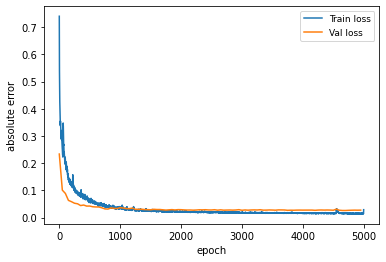

In [ ]:
plt.plot(range(total_epochs),train_loss_list, label = "Train loss")
plt.plot(range(0,total_epochs,50),val_loss_list, label = "Val loss")

plt.xlabel("epoch")
plt.ylabel("absolute error")
plt.legend(loc=1, prop={'size': 9})

In [ ]:
ytest = model(X_test)



total_x_test = forward_model(ytest)




numpy_x_pred = total_x_test.cpu().detach().numpy()
response_pred=pd.DataFrame(numpy_x_pred)

numpy_y_pred = ytest.cpu().detach().numpy()
design_pred=pd.DataFrame(numpy_y_pred)

numpy_y_actual = y_test.cpu().detach().numpy()
design_actual=pd.DataFrame(numpy_y_actual)

numpy_x_actual = X_test.cpu().detach().numpy()
#numpy_x_actual = X_test.cpu().detach().numpy()
response_actual = pd.DataFrame(numpy_x_actual)



'\nnumpy_y_pred = ytest.detach().numpy()\nresponse_pred=pd.DataFrame(numpy_y_pred)\n\nnumpy_y_actual = y_test.detach().numpy()\nresponse_actual=pd.DataFrame(numpy_y_actual)\n\nnumpy_x_actual = X_test.detach().numpy()\ndesign_actual = pd.DataFrame(numpy_x_actual)\n'

In [ ]:
from sklearn.metrics import mean_absolute_error
print("p MAE:", mean_absolute_error(design_pred[design_pred.columns[0]], design_actual[design_actual.columns[0]]))
print("t2 MAE:", mean_absolute_error(design_pred[design_pred.columns[1]], design_actual[design_actual.columns[1]]))
print("gap MAE:", mean_absolute_error(design_pred[design_pred.columns[2]], design_actual[design_actual.columns[2]]))
print("t MAE:", mean_absolute_error(design_pred[design_pred.columns[3]], design_actual[design_actual.columns[3]]))
print("Design MAE:", mean_absolute_error(design_pred, design_actual))
#"""
print("Abs MAE:", mean_absolute_error(response_pred[response_pred.columns[:40]], response_actual[response_actual.columns[:40]]))
print("Imag MAE:", mean_absolute_error(response_pred[response_pred.columns[40:80]], response_actual[response_actual.columns[40:80]]))
print("Real MAE:", mean_absolute_error(response_pred[response_pred.columns[80:]], response_actual[response_actual.columns[80:]]))
print("Real ref MAE:", mean_absolute_error(response_pred, response_actual))

#"""

p MAE: 0.038371015
t2 MAE: 0.020497594
gap MAE: 0.027614508
t MAE: 0.017914636
Design MAE: 0.026099443
Abs MAE: 0.037854437
Imag MAE: 0.0355385
Real MAE: 0.029904444
Real ref MAE: 0.03443246


In [ ]:
"""
Real ref MAE: 0.014028428
Imag ref MAE: 0.013966705
Absorption MAE: 0.020597955
"""

'\nReal ref MAE: 0.014028428\nImag ref MAE: 0.013966705\nAbsorption MAE: 0.020597955\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
